# Image Denoising with Perona-Malik Diffusion Algorithm

## Implementation

In [1]:
import numpy as np
import warnings
import math
from matplotlib import pyplot as plt
from PIL import Image
import requests
from io import BytesIO

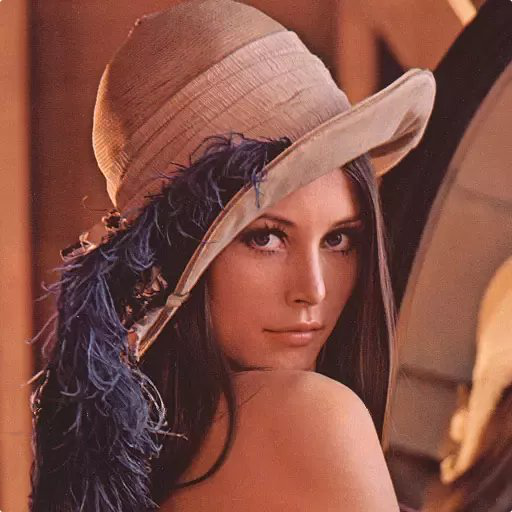

In [2]:
response = requests.get("https://pbs.twimg.com/media/DJjGHANUEAADO2c.jpg")
image = Image.open(BytesIO(response.content))
image

Convert the image to black-and-white and normalize the range:

In [3]:
def convert(original):
    original = np.array(image.convert('L'))
    original_min, original_max = original.min(), original.max()
    orig = (original - original_min) / (float)(original_max - original_min)
    return orig

In [4]:
def display(im):
    return Image.fromarray(np.uint8(im*255))

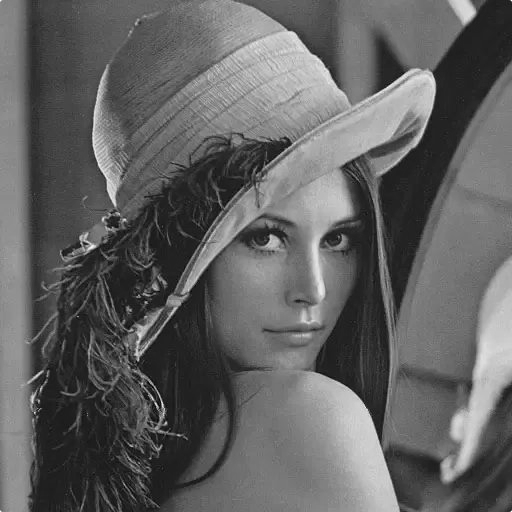

In [5]:
orig = convert(image)
display(orig)

Define stopping functions:

In [6]:
def f1(dt,b):
    return np.exp(-1* (np.power(dt,2))/(np.power(b,2)))

In [7]:
def f2(dt,b): 
    func = 1/(1 + ((dt/b)**2))
    return func

Define anisotropic diffusion function:

In [8]:
def anisodiff(im, steps, b, l = 0.25): 
    temp = np.zeros(im.shape, dtype=im.dtype) 
    for t in range(steps): 
        dn = im[:-2,1:-1] - im[1:-1,1:-1] 
        ds = im[2:,1:-1] - im[1:-1,1:-1] 
        de = im[1:-1,2:] - im[1:-1,1:-1] 
        dw = im[1:-1,:-2] - im[1:-1,1:-1] 
        temp[1:-1,1:-1] = im[1:-1,1:-1] +\
                            l * (f1(dn,b)*dn + f1(ds,b)*ds + 
                                    f1(de,b)*de + f1(dw,b)*dw) 
        im = temp 
    return im

Different types of noise:

In [9]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col = image.shape
        mean = 0
        var = 0.01
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "sp":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy

In [10]:
noise_g = noisy("gauss", orig)
noise_p = noisy("poisson", orig)
noise_sp = noisy("sp", orig)
noise_speckle = noisy("speckle", orig)

Test denoising on different examples:

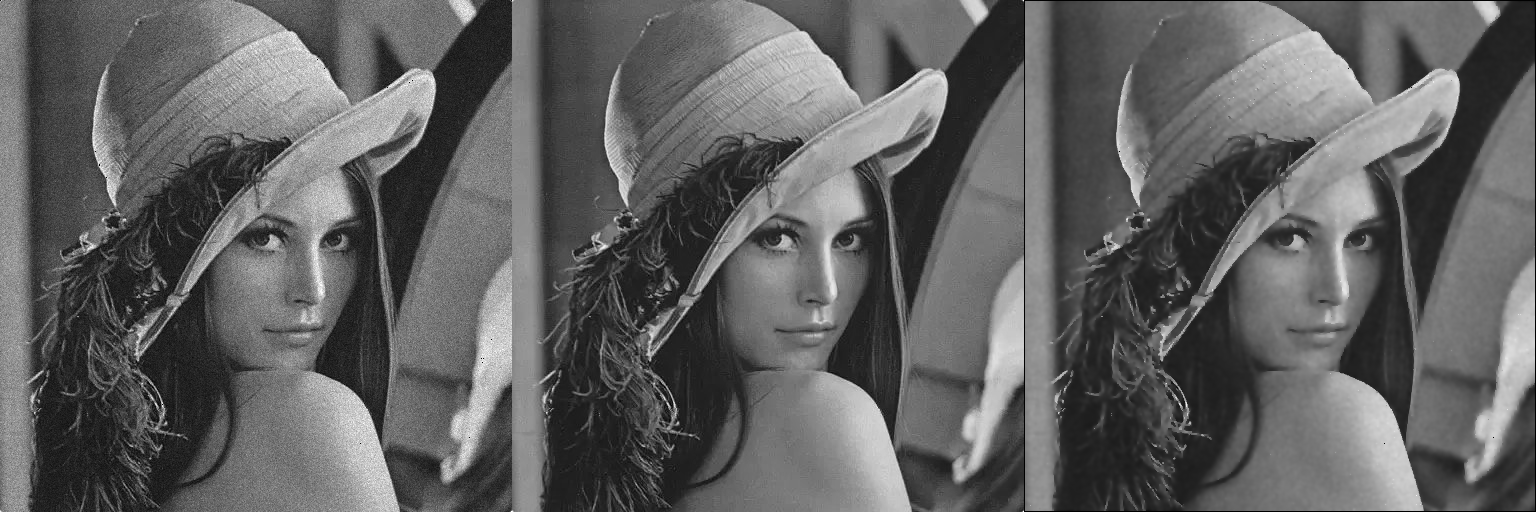

In [11]:
denoised_p = anisodiff(noise_p, 10, 0.1, 0.15)
result_p = Image.fromarray(np.hstack((np.uint8(noise_p*255),np.uint8(orig*255), np.uint8(denoised_p*255))))
result_p

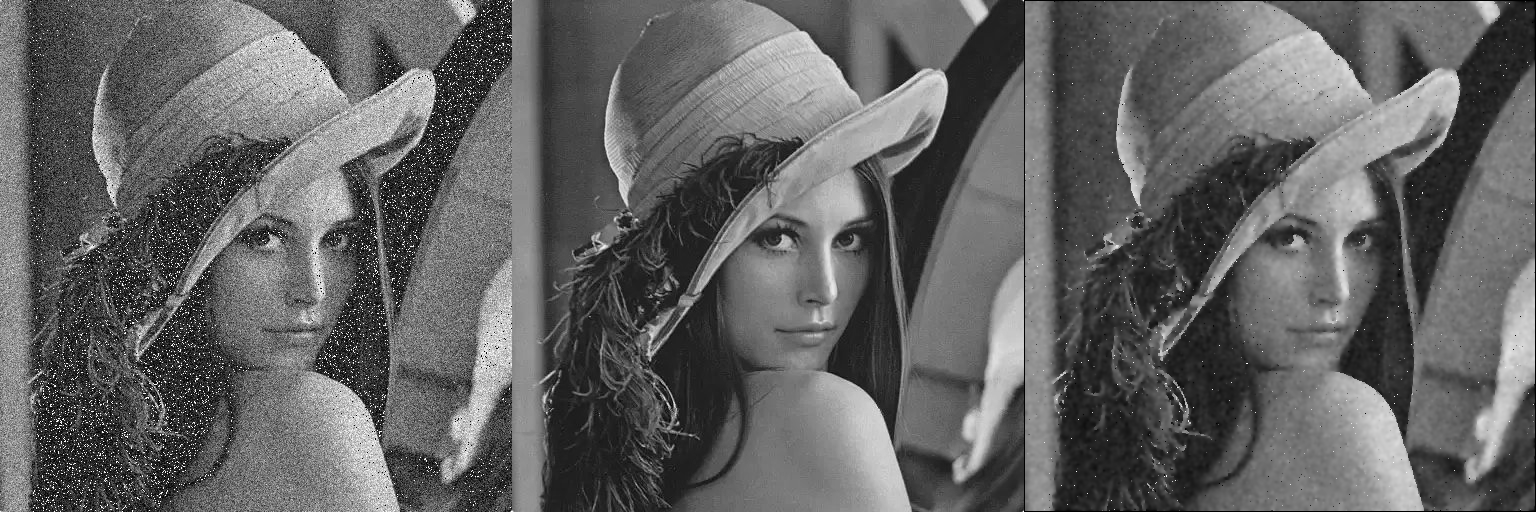

In [12]:
denoised_g = anisodiff(noise_g, 13, 0.15, 0.15)
result_g = Image.fromarray(np.hstack((np.uint8(noise_g*255),np.uint8(orig*255), np.uint8(denoised_g*255))))
result_g

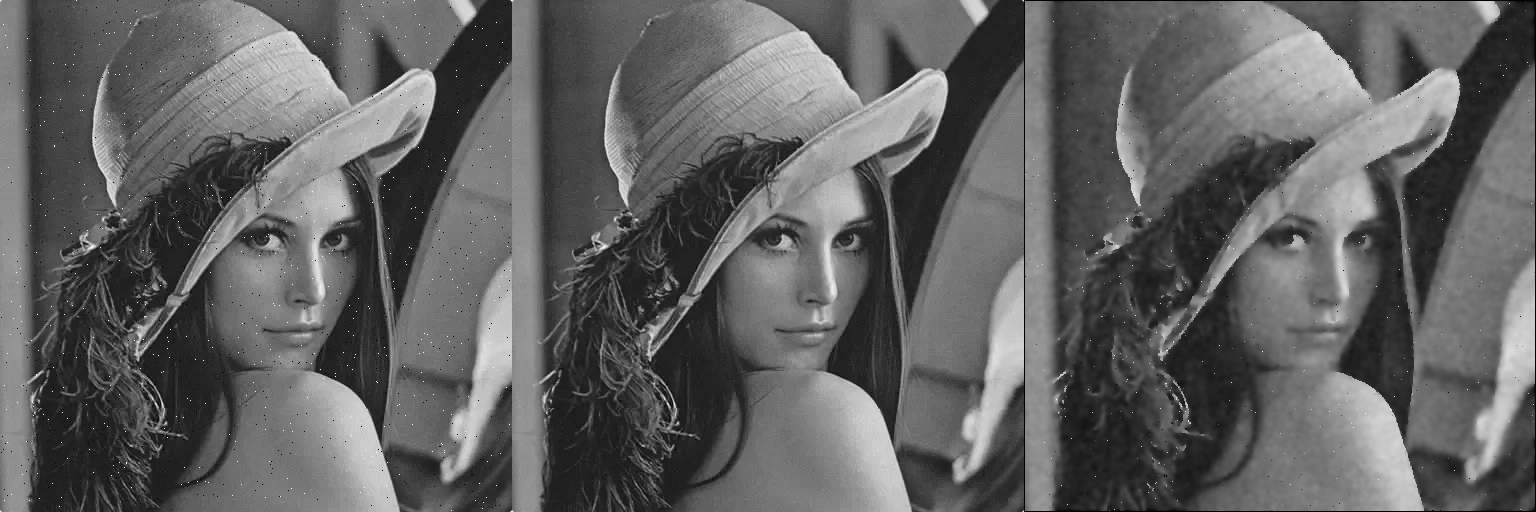

In [13]:
denoised_sp = anisodiff(noise_g, 15, 0.15, 0.2)
result_sp = Image.fromarray(np.hstack((np.uint8(noise_sp*255),np.uint8(orig*255), np.uint8(denoised_sp*255))))
result_sp

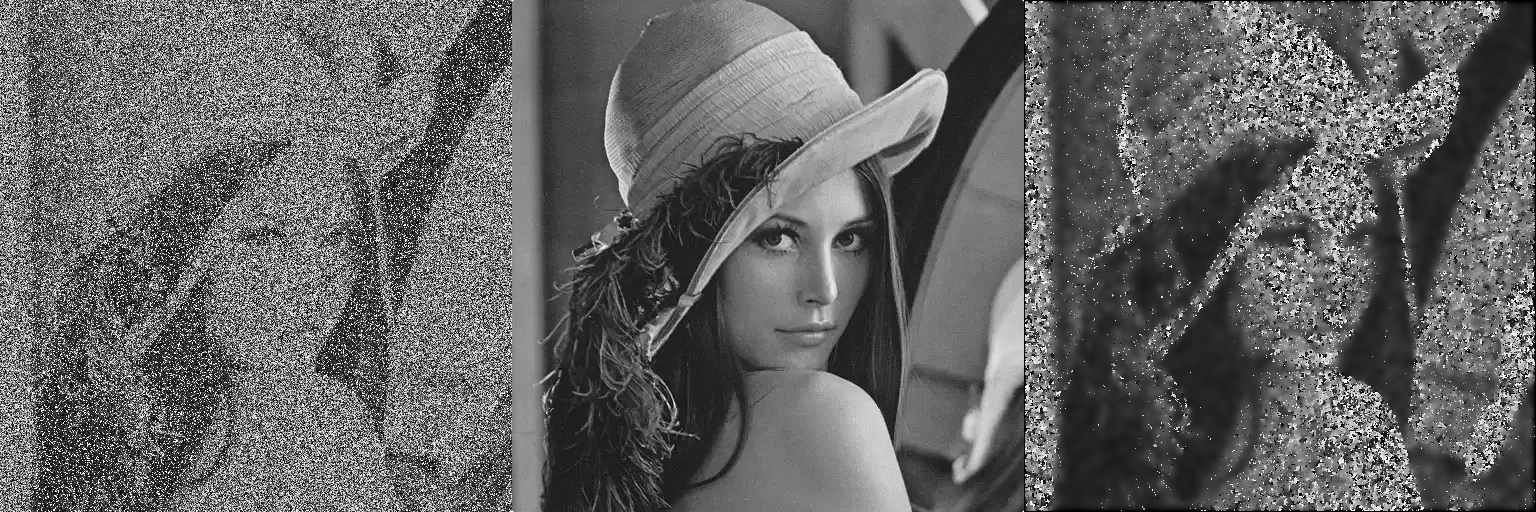

In [14]:
denoised_spe = anisodiff(noise_speckle, 40, 0.25, 0.2)
result_spe = Image.fromarray(np.hstack((np.uint8(noise_speckle*255),np.uint8(orig*255), np.uint8(denoised_spe*255))))
result_spe

Test with another stopping condition: 

In [15]:
def anisodiff2(im, steps, b, l = 0.25): 
    temp = np.zeros(im.shape, dtype=im.dtype) 
    for t in range(steps): 
        dn = im[:-2,1:-1] - im[1:-1,1:-1] 
        ds = im[2:,1:-1] - im[1:-1,1:-1] 
        de = im[1:-1,2:] - im[1:-1,1:-1] 
        dw = im[1:-1,:-2] - im[1:-1,1:-1] 
        temp[1:-1,1:-1] = im[1:-1,1:-1] +\
                            l * (f2(dn,b)*dn + f2(ds,b)*ds + 
                                    f2(de,b)*de + f2(dw,b)*dw) 
        im = temp 
    return im

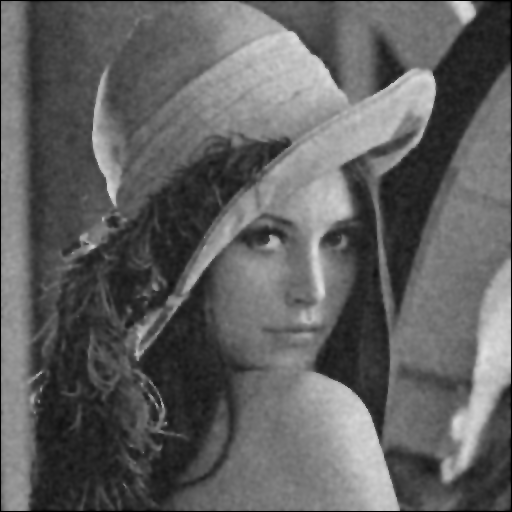

In [16]:
denoised_galt = anisodiff2(noise_g, 13, 0.15, 0.15)
display(denoised_galt)

## Comparison with other methods

### Fast Fourier Transform

In [17]:
def denoise_fft(im, keep_fraction):
    F = np.fft.fft2(im)
    ff = F.copy()
    r,c = ff.shape
    ff[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
    ff[:,int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
    im_new = np.fft.ifft2(ff).real
    return im_new

In [18]:
fftp = denoise_fft(noise_p, 0.2)
fftg = denoise_fft(noise_g, 0.2)
fftsp = denoise_fft(noise_sp, 0.2)
fftspeckle = denoise_fft(noise_speckle, 0.2)

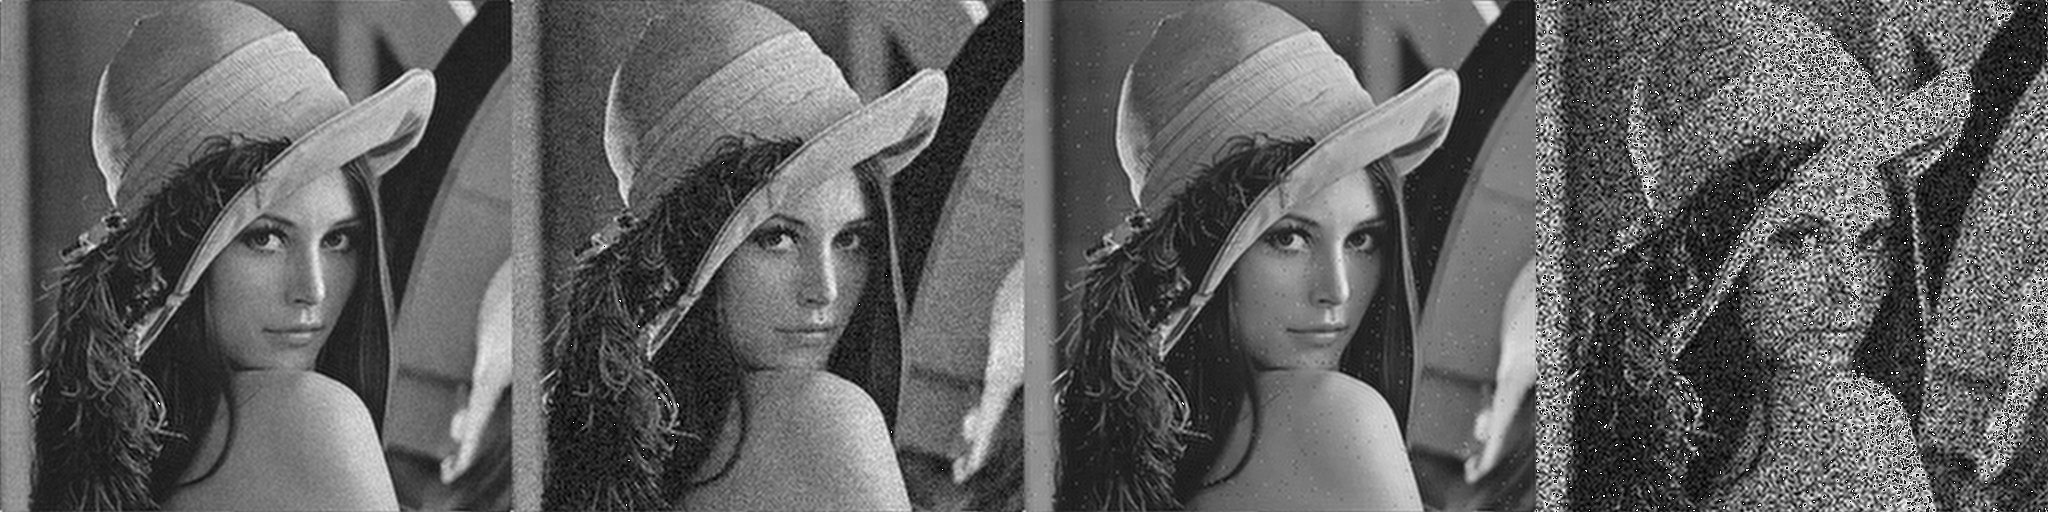

In [19]:
Image.fromarray(np.hstack((np.uint8(fftp*255),np.uint8(fftg*255), np.uint8(fftsp*255), np.uint8(fftspeckle*255))))

### Gaussian Blur

In [20]:
def gblur(a):
    kernel = np.array([[1.0,2.0,1.0], [2.0,4.0,2.0], [1.0,2.0,1.0]])
    kernel = kernel / np.sum(kernel)
    arraylist = []
    for y in range(3):
        temparray = np.copy(a)
        temparray = np.roll(temparray, y - 1, axis=0)
        for x in range(3):
            temparray_X = np.copy(temparray)
            temparray_X = np.roll(temparray_X, x - 1, axis=1)*kernel[y,x]
            arraylist.append(temparray_X)

    arraylist = np.array(arraylist)
    arraylist_sum = np.sum(arraylist, axis=0)
    return arraylist_sum

In [21]:
gbp = gblur(noise_p)
gbg = gblur(noise_g)
gbs = gblur(noise_sp)
gbspe = gblur(noise_speckle)

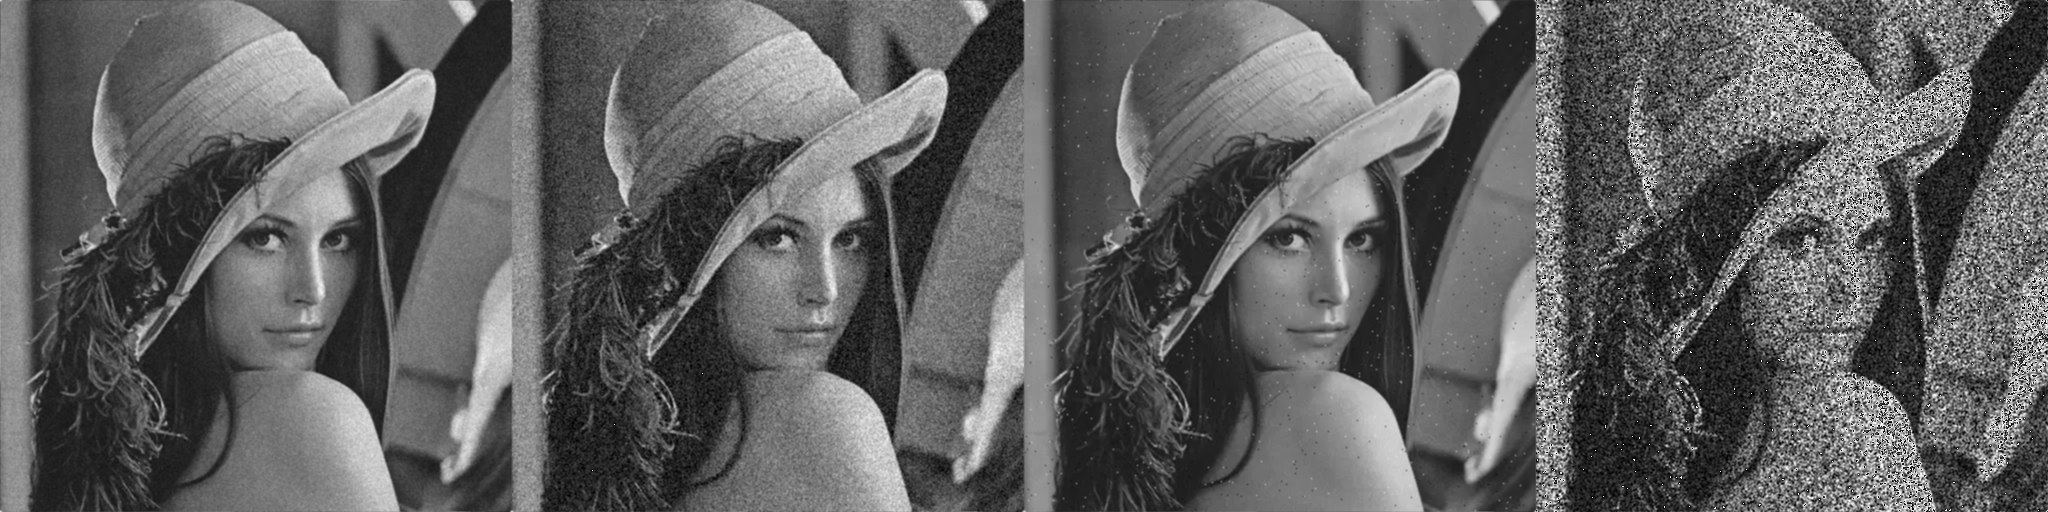

In [22]:
Image.fromarray(np.hstack((np.uint8(gbp*255),np.uint8(gbg*255), np.uint8(gbs*255), np.uint8(gbspe*255))))

### Metrics for evaluation - PSNR and MSE

In [23]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    pix_max = 255.0
    return 20 * math.log10(pix_max / math.sqrt(mse))

#returns similarity 

In [24]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

#the smaller is the error, the more similar are the images

In [ ]:
print('PSNR for gaussian blur noise denoised with anisotorpic diffusion with f1: ', psnr(orig, denoised_sp))
print('PSNR for gaussian blur noise denoised with gaussian blur: ', psnr(orig, gbs))
print('PSNR for gaussian blur noise denoised with FFT: ', psnr(orig, fftsp))